In [186]:
import numpy as np
import pandas as pd

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk mengevaluasi performa model
from sklearn.metrics import f1_score

# Untuk melakukan ekstraksi data pada suatu kolom
import re 

# Membagi dataset menjadi train dan test set
from sklearn.model_selection import train_test_split

import time
import warnings
warnings.filterwarnings('ignore')

# Set rows ke 100 agar dapat melihat data lebih banyak
pd.set_option('display.max_rows', 100)

In [187]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import optuna
from optuna.samplers import TPESampler

In [188]:
X = pd.read_csv("train_features.csv")
y = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_features.csv")
test = test.drop(['ID'], axis=1)
submission_format = pd.read_csv("submission_format.csv")

In [189]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    # summ['top value'] = desc['top'].values
    # summ['Freq'] = desc['freq'].values

    return summ

In [190]:
summary(X).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,object,189,0,6,nan,nan,nan,nan
status_pernikahan,object,212,0,6,nan,nan,nan,nan
pendapatan,float64,190,0,3622,5073000.000000,332884000.000000,114483170.089606,43460423.969516
jumlah_anak_balita,float64,190,0,3,0.000000,2.000000,0.293080,0.473063
jumlah_anak_remaja,float64,204,0,3,0.000000,2.000000,0.353723,0.493014
terakhir_belanja,float64,172,0,113,0.000000,128.000000,47.231550,27.068512
belanja_buah,float64,181,0,2535,0.000000,396508.000000,59804.239824,74024.976109
belanja_daging,float64,178,0,2951,0.000000,3489675.000000,438574.823853,512042.740059
belanja_ikan,float64,193,0,2627,0.000000,621600.000000,81428.997792,99976.226855


In [191]:
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,object,204,0,6,nan,nan,nan,nan
status_pernikahan,object,182,0,6,nan,nan,nan,nan
pendapatan,float64,203,0,3610,2998899.000000,1305740000.000000,116324904.534716,51051222.459486
jumlah_anak_balita,float64,209,0,3,0.000000,2.000000,0.282904,0.465005
jumlah_anak_remaja,float64,210,0,3,0.000000,2.000000,0.355322,0.496865
terakhir_belanja,float64,201,0,116,0.000000,133.000000,47.181366,26.940287
belanja_buah,float64,186,0,2573,0.000000,408646.000000,61234.083425,76647.590617
belanja_daging,float64,195,0,2943,0.000000,3271191.000000,452848.379796,512320.643716
belanja_ikan,float64,196,0,2660,0.000000,574932.000000,85338.612093,103789.546199


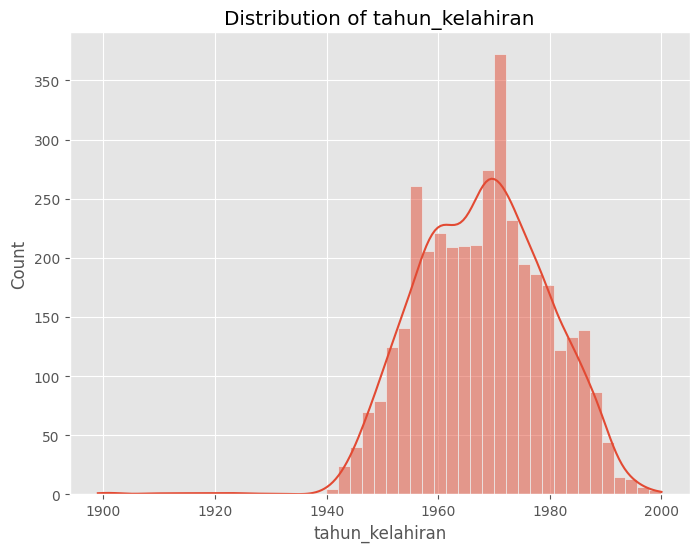

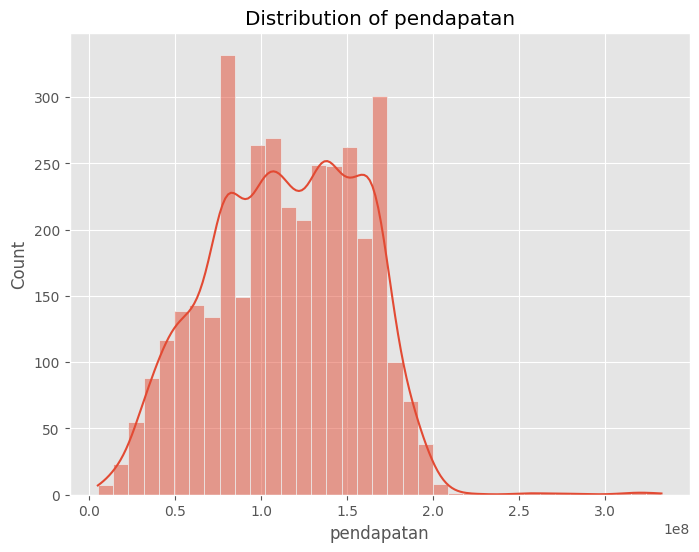

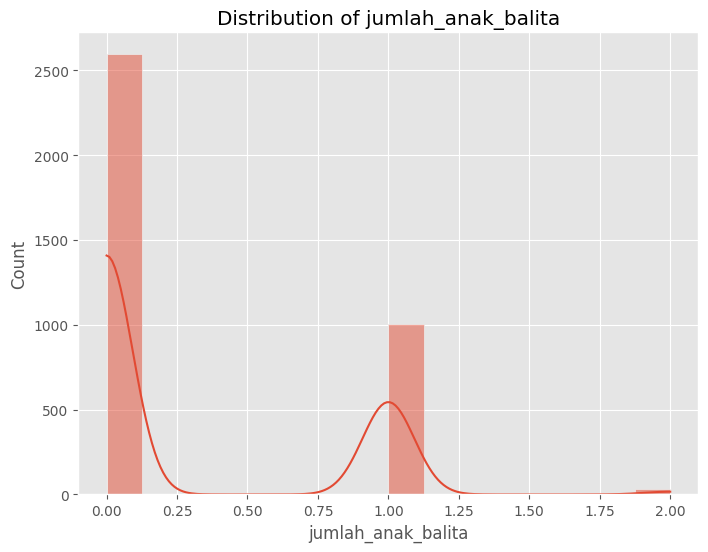

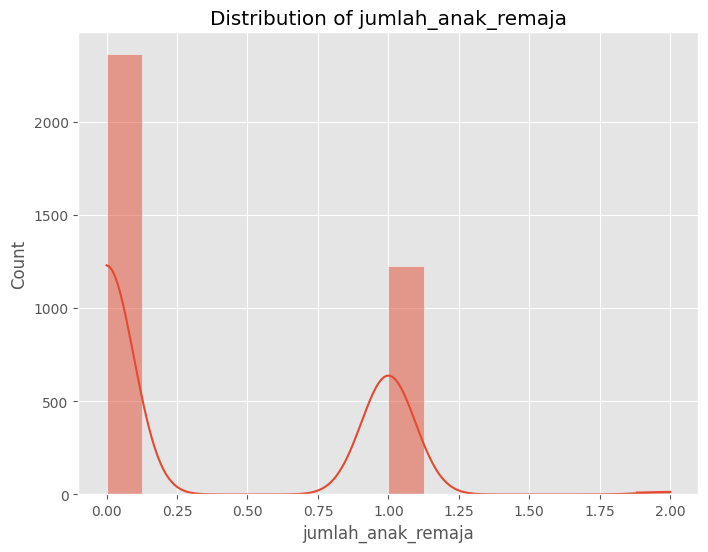

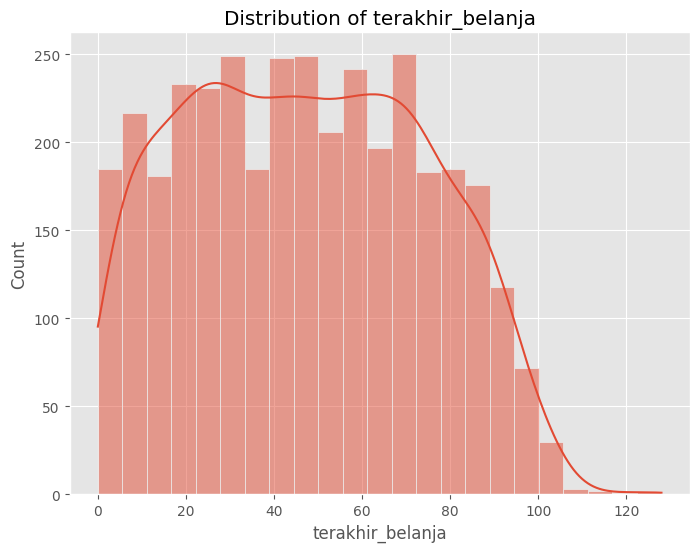

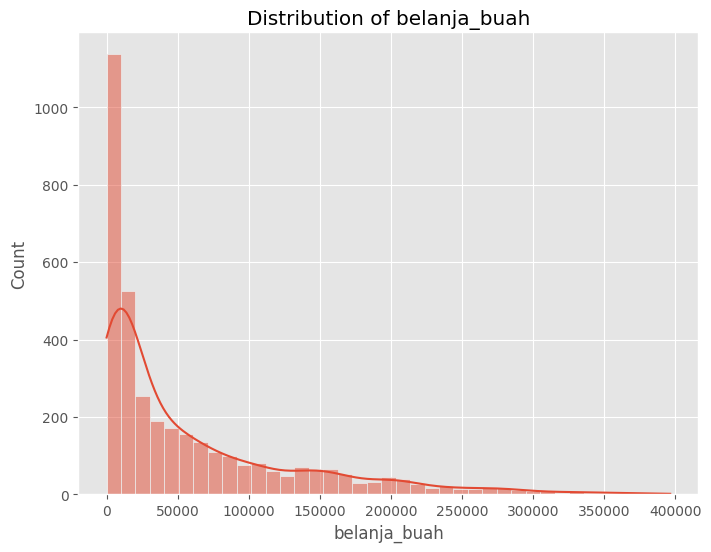

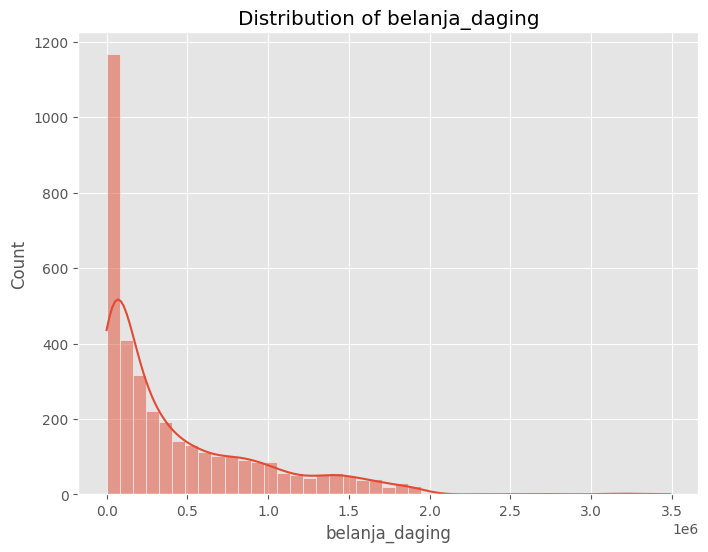

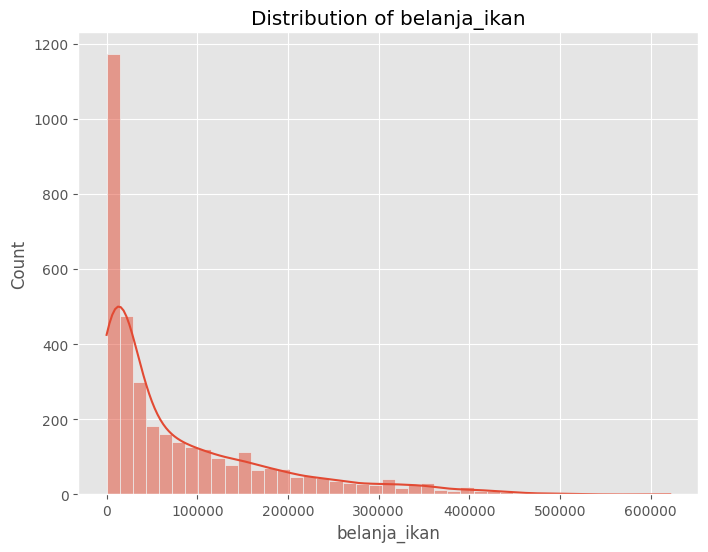

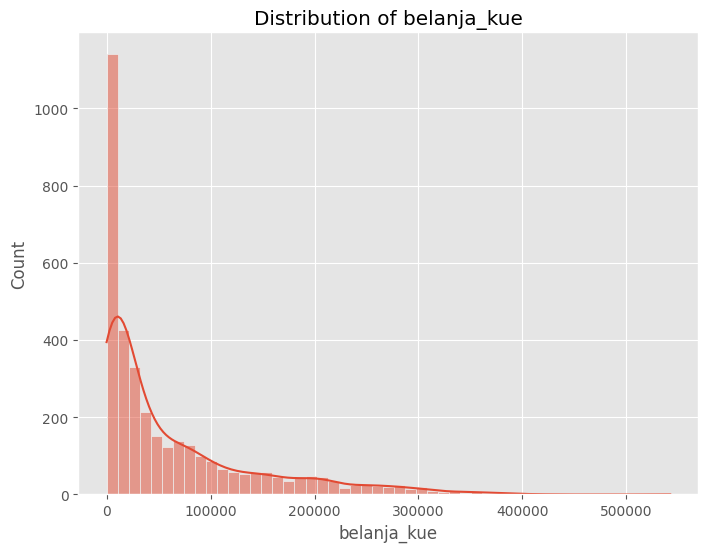

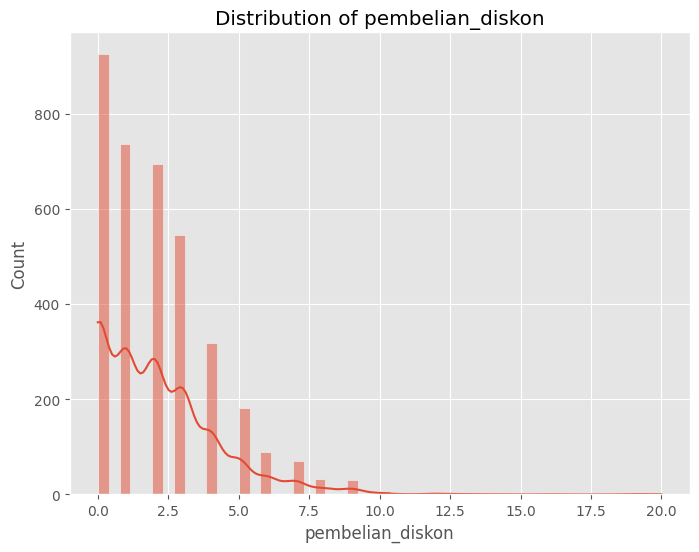

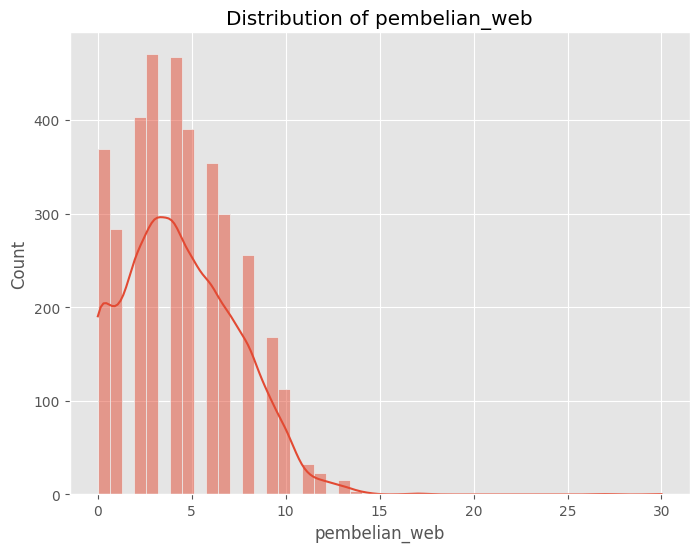

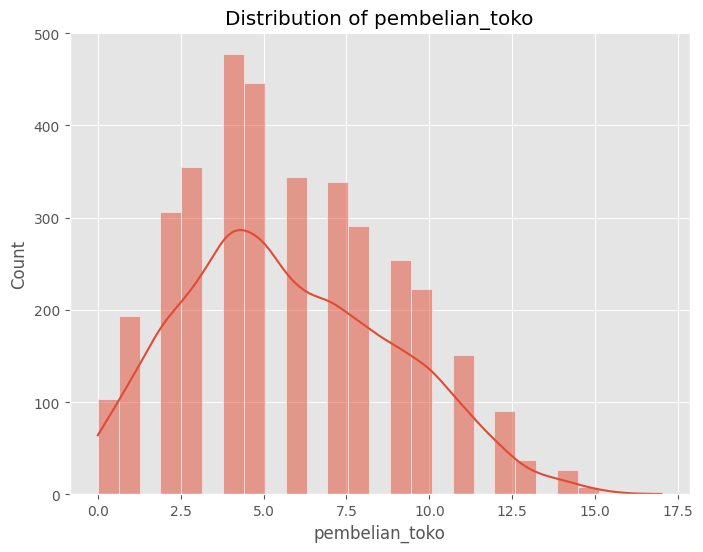

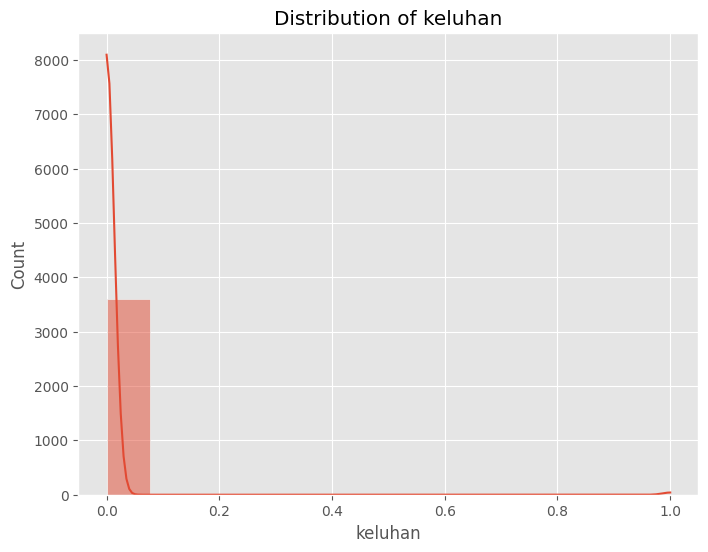

In [192]:
# Plot histograms for numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


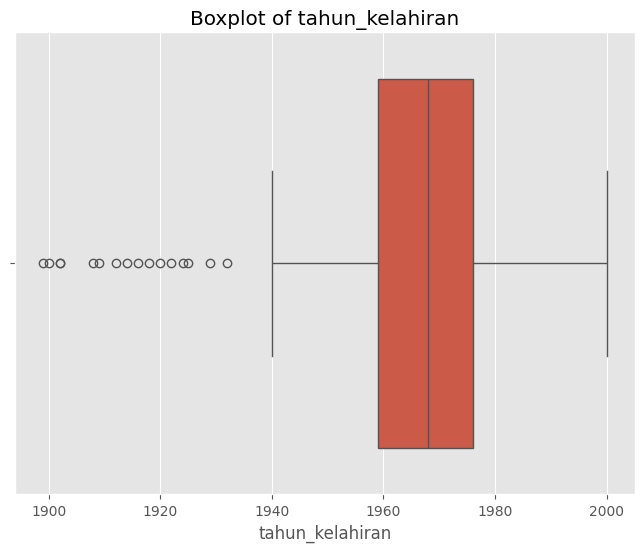

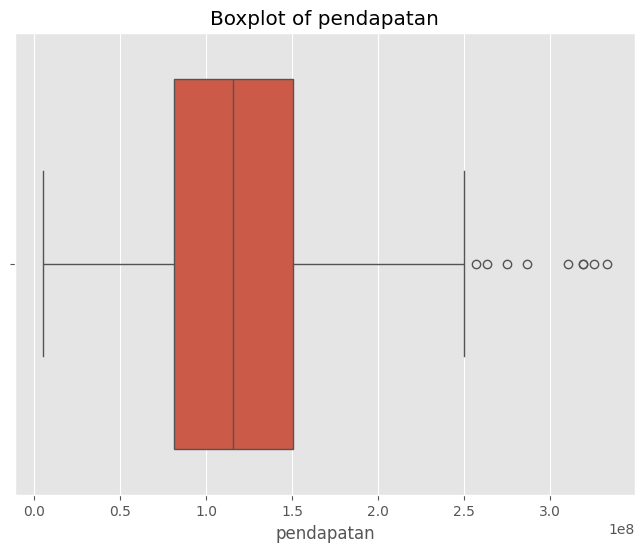

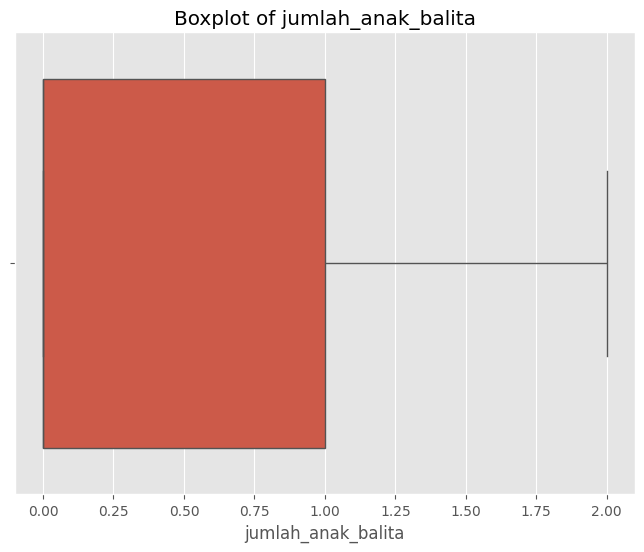

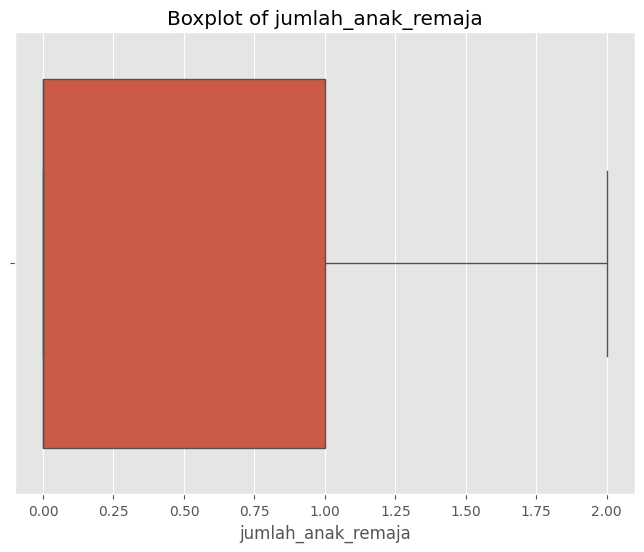

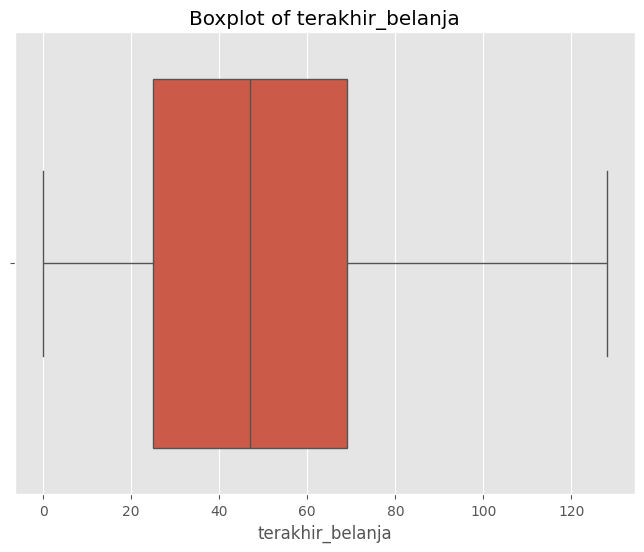

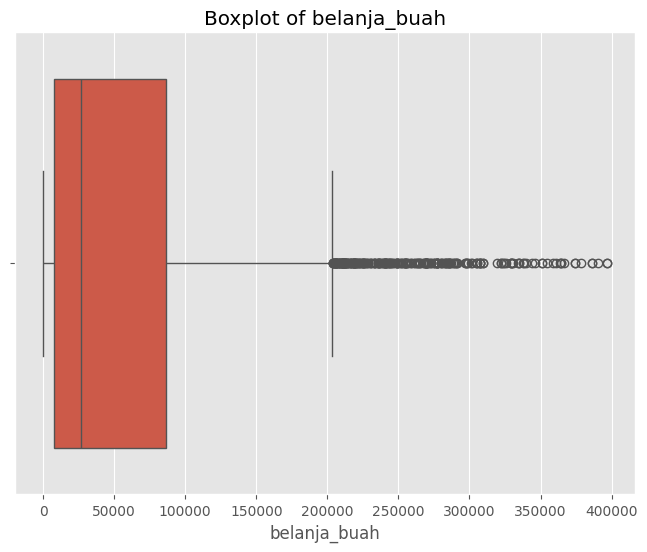

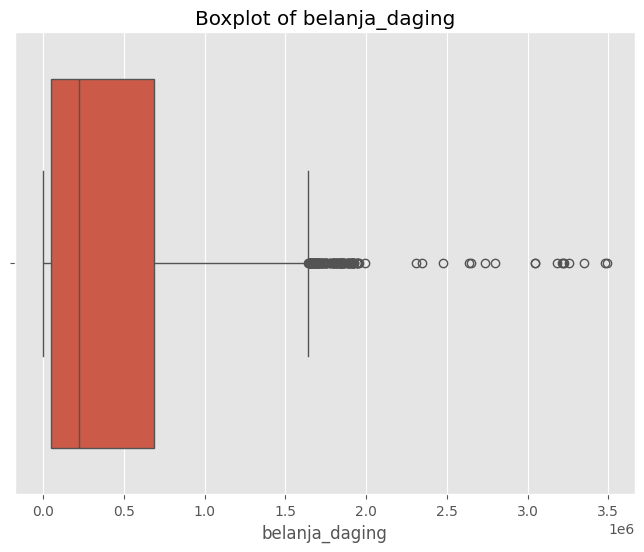

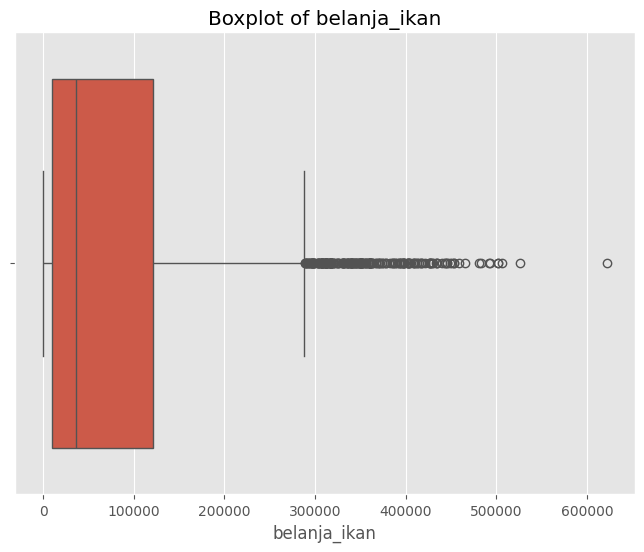

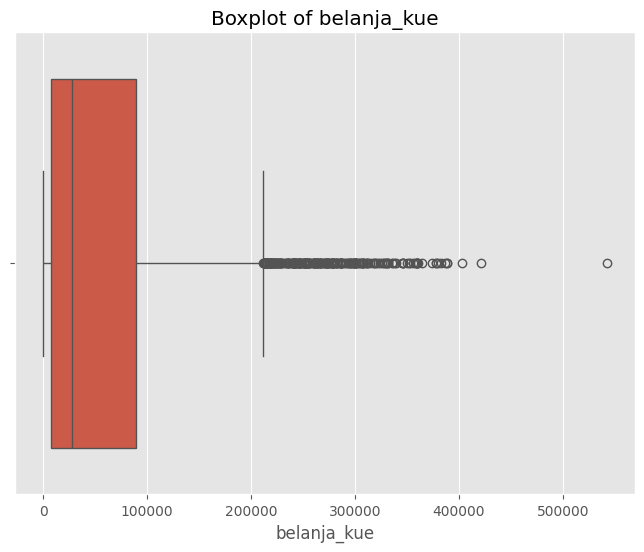

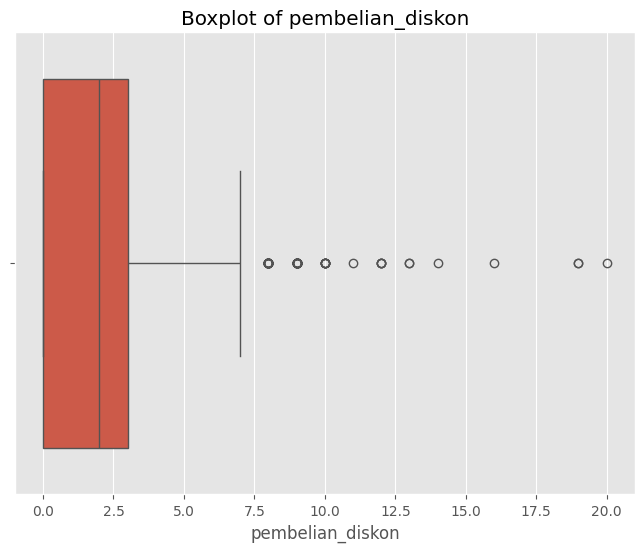

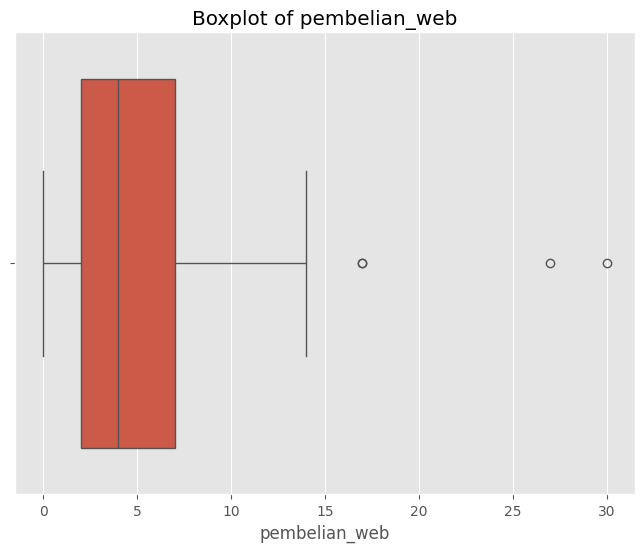

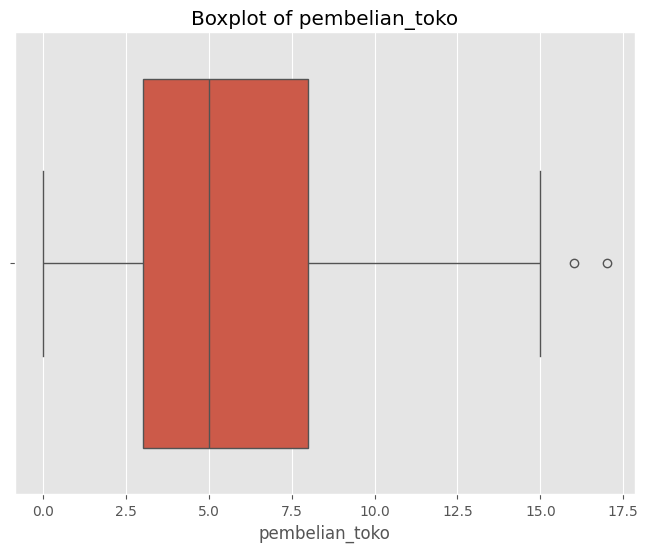

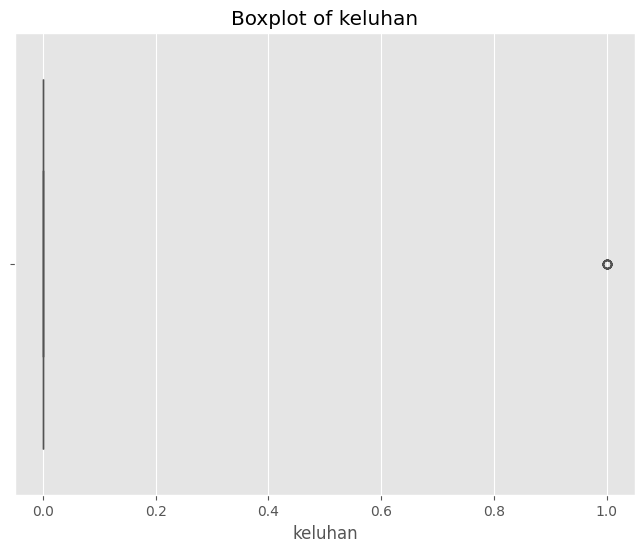

In [193]:
# Plot boxplots for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


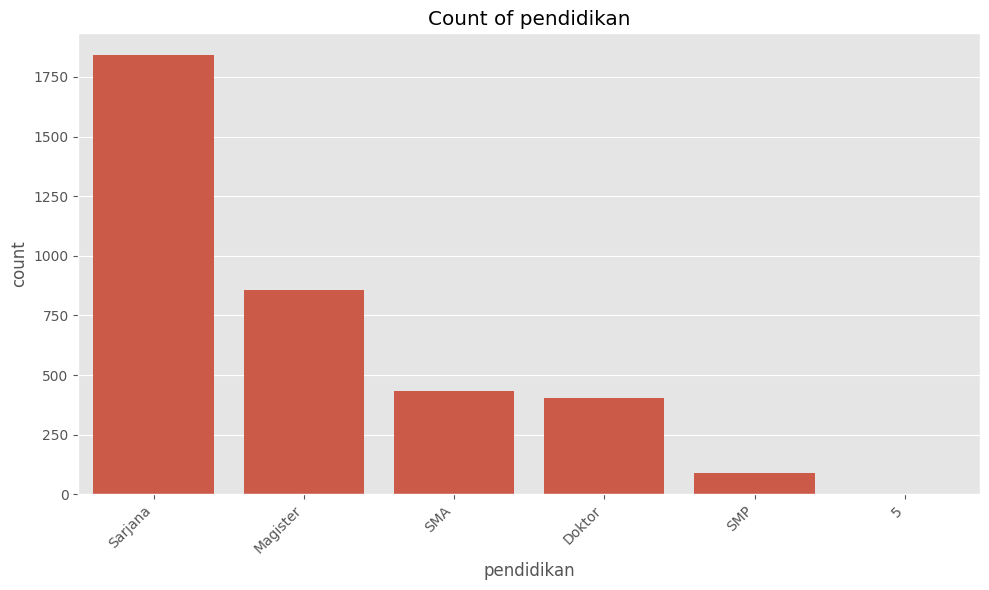

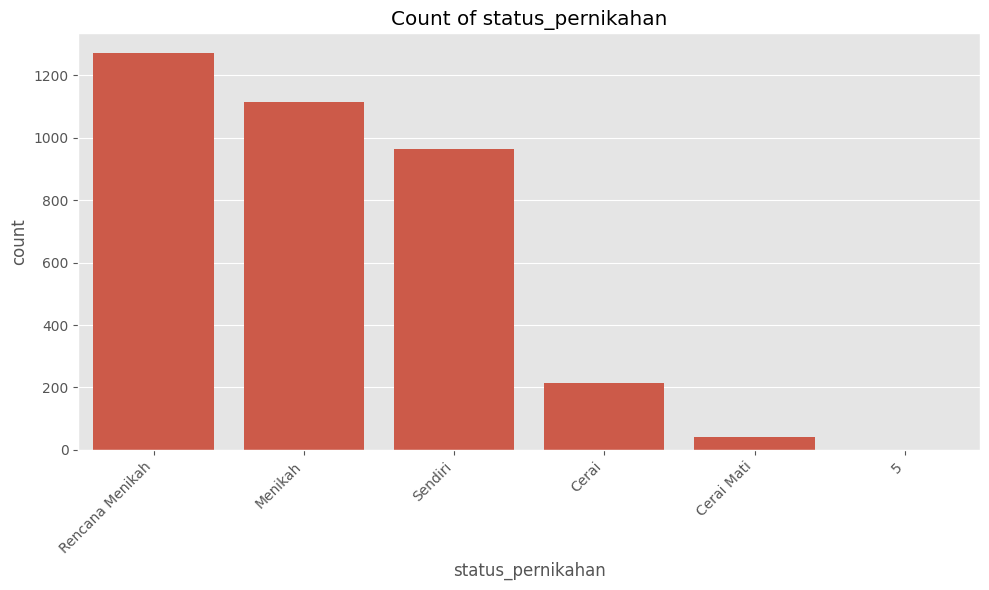

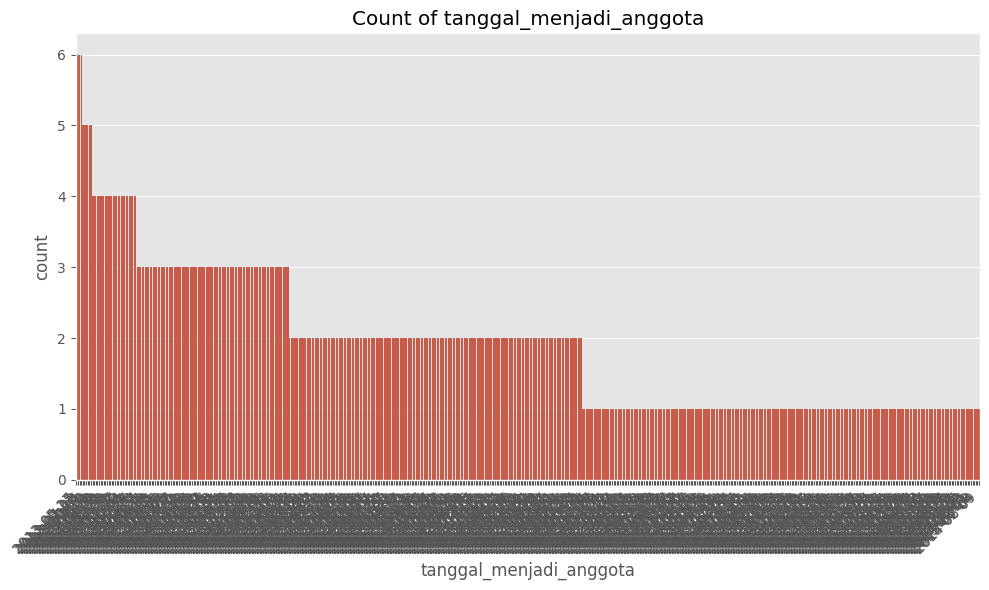

In [194]:
# Plot count plots for categorical columns
# Assuming X is your DataFrame containing categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.countplot(x=X[col], order=X[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
    plt.show()


In [195]:
train = pd.concat([X, y], axis=1)

In [196]:
train.sample(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
119,1968,Doktor,Sendiri,107853965.0,0.0,1.0,46.0,13202.0,2386.0,15496.0,7122.0,1.0,1.0,5.0,0.0,NaN,0
2978,1964,Magister,Rencana Menikah,NaN,0.0,0.0,73.0,117805.0,1683704.0,93281.0,22873.0,NaN,5.0,7.0,0.0,NaN,5
3428,1983,Magister,Sendiri,130696414.0,NaN,0.0,46.0,33234.0,601109.0,38627.0,91123.0,2.0,3.0,5.0,0.0,NaN,5
1776,1962,Sarjana,Rencana Menikah,57444000.0,1.0,1.0,7.0,6069.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,2013-03-09,0
13,1979,SMP,Menikah,14967000.0,NaN,0.0,65.0,34391.0,30345.0,32368.0,0.0,0.0,5.0,2.0,0.0,2012-11-14,0
717,1977,SMA,Rencana Menikah,100767199.0,0.0,0.0,53.0,32629.0,3048446.0,45768.0,36117.0,0.0,0.0,3.0,0.0,NaN,3
269,1965,Sarjana,Menikah,140401982.0,0.0,0.0,78.0,73988.0,579428.0,104277.0,143237.0,NaN,5.0,10.0,0.0,NaN,3
1616,1961,Magister,Sendiri,172547516.0,0.0,0.0,60.0,145996.0,1440656.0,246348.0,226723.0,0.0,4.0,12.0,0.0,NaN,6
1864,1952,Sarjana,Rencana Menikah,166102374.0,0.0,0.0,83.0,47933.0,1115556.0,85232.0,107148.0,0.0,9.0,6.0,0.0,NaN,4
2617,1989,Sarjana,Menikah,59036000.0,0.0,0.0,23.0,6069.0,60690.0,34391.0,NaN,3.0,NaN,3.0,0.0,2013-07-09,0


Text(0, 0.5, 'Percentage')

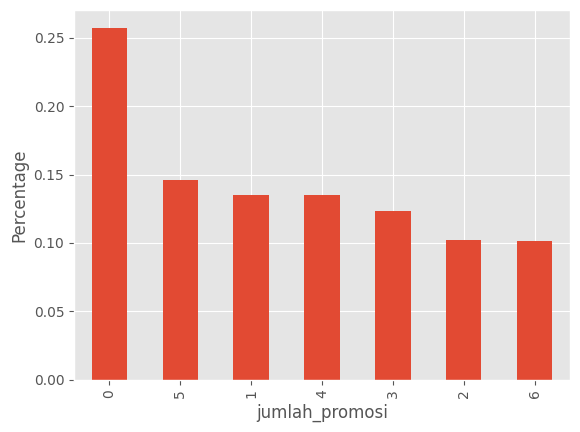

In [197]:
train['jumlah_promosi'].value_counts(normalize = True).plot(kind = 'bar')
plt.ylabel('Percentage')

In [198]:
columns_to_scale = [col for col in train.columns if col != 'jumlah_promosi']
print(columns_to_scale)

['tahun_kelahiran', 'pendidikan', 'status_pernikahan', 'pendapatan', 'jumlah_anak_balita', 'jumlah_anak_remaja', 'terakhir_belanja', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue', 'pembelian_diskon', 'pembelian_web', 'pembelian_toko', 'keluhan', 'tanggal_menjadi_anggota']


In [ ]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [203]:
def feature_engineering(df):
    # Check column existence
    required_columns = ['belanja_daging', 'belanja_ikan', 'belanja_kue', 'belanja_buah', 
                        'pendapatan', 'jumlah_anak_balita', 'jumlah_anak_remaja']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame.")

    # Handle missing values (NaN) if necessary
    df.fillna(0, inplace=True)  # Example: replace NaN with 0

    # Perform feature engineering
    df['jumlah_belanja_pokok'] = df[['belanja_daging', 'belanja_ikan']].sum(axis=1)
    df['jumlah_belanja_non_pokok'] = df[['belanja_kue', 'belanja_buah']].sum(axis=1)
    
    # Calculate ratios
    df['total_belanja'] = df[['belanja_daging', 'belanja_ikan', 'belanja_kue', 'belanja_buah']].sum(axis=1)
    df['ratio_pokok'] = df['jumlah_belanja_pokok'] / df['total_belanja']
    
    # Calculate normalized spending based on income
    df['gaji_yang_dibelanjakan'] = df['total_belanja'] / df['pendapatan']
    
    # Calculate total number of children
    df['jumlah_anak'] = df[['jumlah_anak_balita', 'jumlah_anak_remaja']].sum(axis=1)
    
    # Determine if there are any children
    df['beranak'] = np.where(df['jumlah_anak'] > 0, 1, 0)
    
    df = df.drop(['tahun_kelahiran', 'pendidikan', 'status_pernikahan','jumlah_anak_balita', 'jumlah_anak_remaja','jumlah_anak','terakhir_belanja',
                        'keluhan', 'tanggal_menjadi_anggota', 'belanja_daging', 'belanja_ikan','belanja_kue', 'belanja_buah','pembelian_diskon'], axis=1)
    return df

# Example usage:
# Apply feature engineering to your DataFrame (df)
# df = feature_engineering(df)


In [204]:
def preprocessing(df):
    # df = df.drop(['tahun_kelahiran', 'pendidikan', 'status_pernikahan','jumlah_anak_balita', 'jumlah_anak_remaja','jumlah_anak',
    #                     'keluhan', 'tanggal_menjadi_anggota', 'belanja_daging', 'belanja_ikan','belanja_kue', 'belanja_buah','pembelian_diskon'], axis=1)
    
    # # Fill Null Val dengan median
    # df = df.fillna(df.median())

    # Change data type to int64
    numerical_data = df.select_dtypes(include=[np.number])  # Select numerical columns
    for i, column in enumerate(numerical_data.columns):
        df[column] = df[column].fillna(df[column].median())
        df[column] = df[column].astype('int64')

    return df

In [205]:
train.head

<bound method NDFrame.head of       tahun_kelahiran pendidikan status_pernikahan   pendapatan  \
0                1979    Sarjana   Rencana Menikah          NaN   
1                1950    Sarjana   Rencana Menikah   84063000.0   
2                1966    Sarjana           Menikah  127532564.0   
3                1961   Magister   Rencana Menikah  165579620.0   
4                1970    Sarjana   Rencana Menikah  117703159.0   
...               ...        ...               ...          ...   
3812             1955   Magister           Menikah   78199470.0   
3813             1947     Doktor   Rencana Menikah  109306000.0   
3814             1974   Magister           Menikah  104621000.0   
3815             1957        SMA   Rencana Menikah  110850000.0   
3816             1961    Sarjana           Menikah  130512000.0   

      jumlah_anak_balita  jumlah_anak_remaja  terakhir_belanja  belanja_buah  \
0                    0.0                 1.0               NaN       50575.0   
1    

In [206]:
# Preprocess train set
train = preprocessing(train)
train = feature_engineering(train)
summary(train).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
pendapatan,int64,0,0,3622,5073000.000000,332884000.000000,114539827.816348,42365378.562972
pembelian_web,int64,0,0,18,0.000000,30.000000,4.417605,2.938233
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.733822,3.142808
jumlah_promosi,int64,0,0,7,0.000000,6.000000,2.585800,2.101845
jumlah_belanja_pokok,int64,0,0,3181,0.000000,3489675.000000,507609.548860,559414.114490
jumlah_belanja_non_pokok,int64,0,0,2903,0.000000,714119.000000,119605.897302,133140.895795
total_belanja,int64,0,0,3322,0.000000,3522200.000000,627215.446162,658177.612743
ratio_pokok,float64,1,0,3556,0.000000,1.000000,0.776950,0.145022
gaji_yang_dibelanjakan,float64,0,0,3811,0.000000,0.688689,0.004934,0.013100
beranak,int32,0,0,2,0.000000,1.000000,0.507467,0.500010


In [207]:
# Preprocess test set
test = preprocessing(test)
test = feature_engineering(test)
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
pendapatan,int64,0,0,3610,2998899.000000,1305740000.000000,116399722.873232,49676148.242755
pembelian_web,int64,0,0,16,0.000000,27.000000,4.443164,2.867256
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.794919,3.212271
jumlah_belanja_pokok,int64,0,0,3186,0.000000,3307605.000000,524619.661603,562494.687553
jumlah_belanja_non_pokok,int64,0,0,2944,0.000000,764694.000000,121798.597695,133323.836634
total_belanja,int64,0,0,3342,0.000000,3346042.000000,646418.259298,662817.901152
ratio_pokok,float64,3,0,3571,0.000000,1.000000,0.779408,0.143672
gaji_yang_dibelanjakan,float64,0,0,3812,0.000000,0.558474,0.005056,0.013191
beranak,int32,0,0,2,0.000000,1.000000,0.499738,0.500065


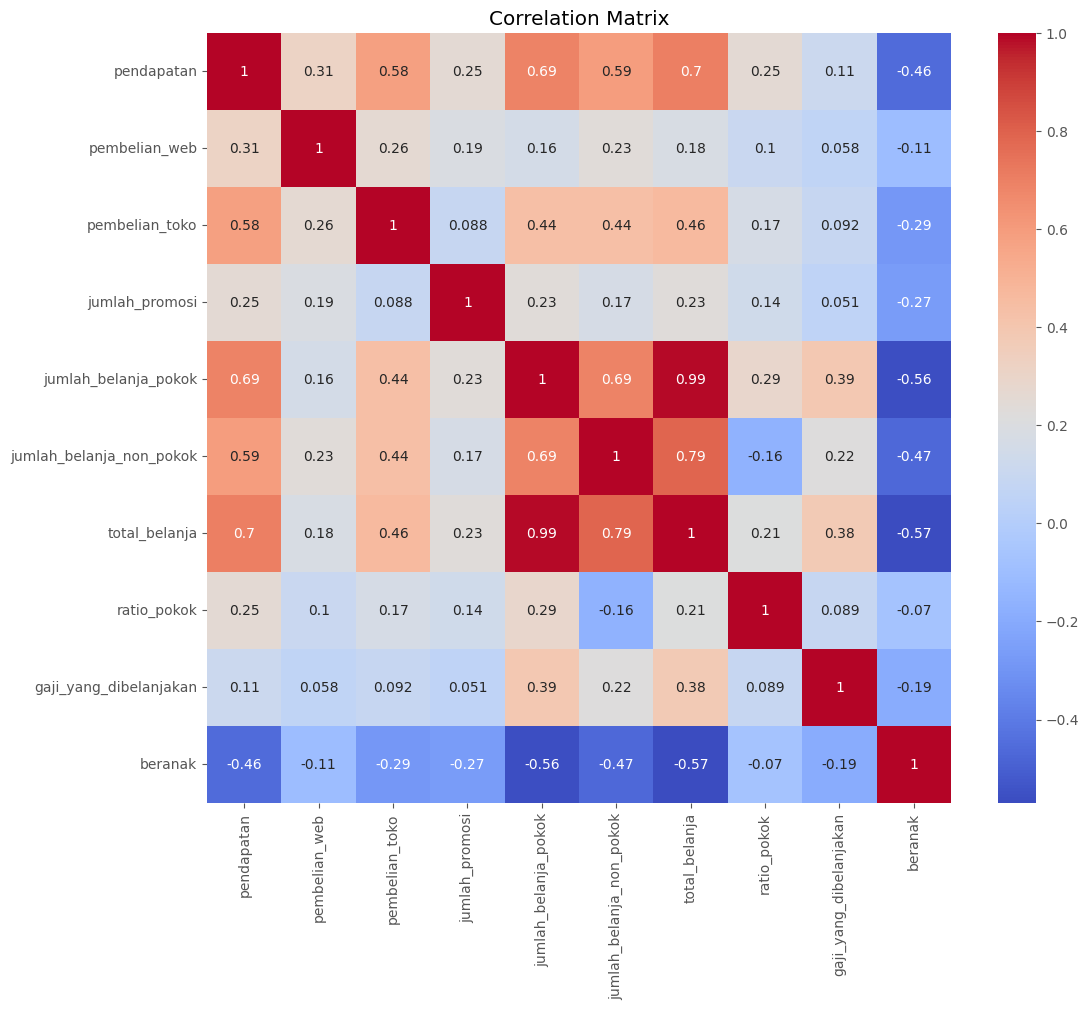

In [208]:
# Menghitung matriks korelasi
corr_matrix = train.corr()

# Membuat plot heatmap 
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [209]:
# # Extract column names excluding 'jumlah_promosi'
# columns_to_scale = [col for col in train.columns if col != 'jumlah_promosi']

# # Initialize MinMaxScaler
# scaler = StandardScaler()

# # Fit and transform the selected columns
# train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
# test = scaler.fit_transform(test)


In [210]:
X = train.drop(columns = ['jumlah_promosi'], axis = 1)
y = train['jumlah_promosi']

In [211]:
skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

In [227]:

# Define the objective function for optimization
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'random_state': 42  # You can add other parameters as needed
    }

    model = XGBClassifier(**params)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        f1_scores.append(f1)

    return np.mean(f1_scores)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train a model with the best hyperparameters
best_model = XGBClassifier(**best_params)
XGB_cv = cross_val_score(best_model, X, y, scoring='f1_macro', cv=skf, n_jobs=-1)

# Print the average 10-folds oof Macro F-Score of the XGBoost model
print(f"The average 10-folds oof Macro F-Score of the XGBoost model is {XGB_cv.mean()}")


[I 2024-04-18 07:15:33,024] A new study created in memory with name: no-name-b4ac986d-04f5-4b68-99f2-f766dbc41d41
[I 2024-04-18 07:15:47,377] Trial 0 finished with value: 0.612176075976561 and parameters: {'max_depth': 6, 'learning_rate': 0.07998119593533139, 'n_estimators': 349, 'gamma': 0.3902598048912713, 'min_child_weight': 1, 'colsample_bytree': 0.9228578142021967, 'subsample': 0.6245124161916078}. Best is trial 0 with value: 0.612176075976561.
[I 2024-04-18 07:16:05,748] Trial 1 finished with value: 0.584712463309682 and parameters: {'max_depth': 6, 'learning_rate': 0.02580566055133999, 'n_estimators': 409, 'gamma': 0.028834321483225296, 'min_child_weight': 3, 'colsample_bytree': 0.9135831090078408, 'subsample': 0.6581991082872651}. Best is trial 0 with value: 0.612176075976561.
[I 2024-04-18 07:16:38,577] Trial 2 finished with value: 0.6110766990801303 and parameters: {'max_depth': 8, 'learning_rate': 0.016490351996756615, 'n_estimators': 666, 'gamma': 0.14745322817759635, 'min_

KeyboardInterrupt: 

In [213]:
%%time
XGB_cv = cross_val_score(XGBClassifier(**{'max_depth': 9, 
                       'learning_rate': 0.05063472718334971, 
                       'n_estimators': 598, 
                       'gamma': 0.011145878108558174, 
                       'min_child_weight': 1, 
                       'colsample_bytree': 0.7910943158431603, 
                       'subsample': 0.836449113768654}), 
                          X,
                          y,
                          scoring = 'f1_macro',
                          cv = skf, 
                          n_jobs = -1)
#Best hyperparameters: {'max_depth': 9, 'learning_rate': 0.04108163274739125, 'n_estimators': 315, 'gamma': 0.030334857515877698, 'min_child_weight': 3, 'colsample_bytree': 0.5033437061093332, 'subsample': 0.8818998210934057}
print(f"The average 10-folds oof Macro F-Score of the XGBoost model is {XGB_cv.mean()}") 

The average 10-folds oof Macro F-Score of the XGBoost model is 0.6399450495521468
CPU times: total: 15.6 ms
Wall time: 10.1 s


In [214]:
%%time
XGB_cv = cross_val_score(XGBClassifier(**{'max_depth': 9, 
                       'learning_rate': 0.05063472718334971, 
                       'n_estimators': 598, 
                       'gamma': 0.011145878108558174, 
                       'min_child_weight': 1, 
                       'colsample_bytree': 0.7910943158431603, 
                       'subsample': 0.836449113768654}), 
                          X,
                          y,
                          scoring = 'f1_macro',
                          cv = skf, 
                          n_jobs = -1)
#Best hyperparameters: {'max_depth': 9, 'learning_rate': 0.04108163274739125, 'n_estimators': 315, 'gamma': 0.030334857515877698, 'min_child_weight': 3, 'colsample_bytree': 0.5033437061093332, 'subsample': 0.8818998210934057}
print(f"The average 10-folds oof Macro F-Score of the XGBoost model is {XGB_cv.mean()}") 

The average 10-folds oof Macro F-Score of the XGBoost model is 0.6399450495521468
CPU times: total: 0 ns
Wall time: 10.1 s


In [215]:
xgb = XGBClassifier(**{'max_depth': 9, 
                       'learning_rate': 0.05063472718334971, 
                       'n_estimators': 598, 
                       'gamma': 0.011145878108558174, 
                       'min_child_weight': 1, 
                       'colsample_bytree': 0.7910943158431603, 
                       'subsample': 0.836449113768654})

xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7910943158431603, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.011145878108558174,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05063472718334971,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=598, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [217]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy','log_loss']),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_int('max_features', 1, 10),
        'random_state': 1,
        'n_jobs': -1
    }

    # Initialize the RandomForestClassifier with the suggested hyperparameters
    rf = RandomForestClassifier(**params)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model and make predictions on the test set
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Calculate F1 score (macro average) as the metric to optimize
    f1 = f1_score(y_test, y_pred, average='macro')

    return f1

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train a model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X, y)

# Use the best model for predictions or further analysis


In [218]:
rf = RandomForestClassifier(**{'n_estimators': 1000,
                                                  'criterion': 'log_loss',
                                                  'max_depth': 30,
                                                  'min_samples_split': 3,
                                                  'min_samples_leaf': 1,
                                                  'max_features': 4,
                                                  'random_state': 1,
                                                  'n_jobs': -1})

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))

F1:  0.5978833252402286


In [219]:
rf = RandomForestClassifier(**{'n_estimators': 947, 
                               'criterion': 'log_loss', 
                               'max_depth': 50, 
                               'min_samples_split': 2, 
                               'min_samples_leaf': 1, 
                               'max_features': 5})

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))

F1:  0.6113223364346366


In [220]:
submission = xgb.predict(test)
submission_df_xgb = pd.DataFrame(submission)

In [221]:
submission = rf.predict(test)
submission_df_rf = pd.DataFrame(submission)

In [222]:
def compare_rows(df1, df2):
    # Check if the two DataFrames have the same shape
    if df1.shape != df2.shape:
        raise ValueError("DataFrames must have the same shape for comparison.")
    
    # Create an empty DataFrame to store the comparison results
    comparison_df = pd.DataFrame(index=df1.index)
    
    # Check if each element in the rows of df1 and df2 are equal
    comparison_df['RowEquals'] = (df1.values == df2.values).all(axis=1)
    
    return comparison_df

# Call the function to compare rows
result_df = compare_rows(submission_df_xgb, submission_df_rf)

# Display the comparison DataFrame
print("Comparison DataFrame:")
print(result_df)

value_counts = result_df.value_counts()
value_counts

Comparison DataFrame:
      RowEquals
0          True
1          True
2          True
3         False
4          True
...         ...
3813       True
3814      False
3815       True
3816       True
3817       True

[3818 rows x 1 columns]


RowEquals
True         3051
False         767
Name: count, dtype: int64

In [223]:
submission = rf.predict(test)
submission_df = pd.DataFrame(submission)

In [224]:
submission_df

,0
0,0
1,0
2,2
3,4
4,4
...,...
3813,0
3814,0
3815,0
3816,4


In [225]:
submission_format['jumlah_promosi'] = submission_df

In [226]:
submission_format.to_csv('submission_y.csv',index = False)